# Model Comparison with TOPSIS

Rank 8 regression models on projectile motion dataset using multi-criteria decision making.

**Features:** launch_angle, initial_velocity, mass, drag_coefficient, gravity
**Target:** horizontal_range

**Criteria:** MAE (30%), RMSE (30%), R² (25%), Training_Time (15%)

## Step 1: Import Libraries and Setup

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from topsis_package import topsis

# Create results directory
Path('results').mkdir(exist_ok=True)

print("Libraries imported successfully")
print("Results directory ready")

✓ Libraries imported successfully
✓ Results directory ready


## Generate Dataset

In [50]:
def compute_horizontal_range(launch_angle, initial_velocity, mass, drag_coefficient, gravity):
    """
    Compute horizontal range using simplified projectile motion with drag effects.
    
    Simplified model that approximates air resistance impact on range.
    """
    angle_rad = np.radians(launch_angle)
    
    # Basic range without drag
    range_no_drag = (initial_velocity ** 2 * np.sin(2 * angle_rad)) / gravity
    
    # Drag factor (simplified): reduces range proportionally
    # Higher drag coefficient and lower mass increase drag effect
    drag_factor = 1 - (drag_coefficient * initial_velocity * 0.01 / mass)
    drag_factor = max(0.3, min(1.0, drag_factor))  # Clamp between 0.3 and 1.0
    
    # Final range with drag
    horizontal_range = range_no_drag * drag_factor
    
    return horizontal_range

# Generate dataset
np.random.seed(42)
n_samples = 1000

data = {
    'launch_angle': np.random.uniform(15, 75, n_samples),
    'initial_velocity': np.random.uniform(10, 50, n_samples),
    'mass': np.random.uniform(0.1, 2.0, n_samples),
    'drag_coefficient': np.random.uniform(0.1, 0.8, n_samples),
    'gravity': np.random.uniform(9.5, 10.0, n_samples)
}

df_sim = pd.DataFrame(data)

# Compute target variable
df_sim['horizontal_range'] = df_sim.apply(
    lambda row: compute_horizontal_range(
        row['launch_angle'],
        row['initial_velocity'],
        row['mass'],
        row['drag_coefficient'],
        row['gravity']
    ),
    axis=1
)

# Save dataset
df_sim.to_csv('data/simulation_data.csv', index=False)

print(f"Dataset generated: {n_samples} samples")
print(f"\nDataset shape: {df_sim.shape}")
print(f"\nFirst 5 rows:")
print(df_sim.head())
print(f"\nTarget statistics:")
print(df_sim['horizontal_range'].describe())

Dataset generated: 1000 samples

Dataset shape: (1000, 6)

First 5 rows:
   launch_angle  initial_velocity      mass  drag_coefficient   gravity  \
0     37.472407         17.405317  0.597241          0.570892  9.785998   
1     72.042858         31.676038  0.569260          0.657677  9.902716   
2     58.919637         44.917833  1.821884          0.275328  9.880080   
3     50.919509         39.288995  0.574138          0.537412  9.576950   
4     24.361118         42.262446  0.616704          0.500222  9.574625   

   horizontal_range  
0         24.920760  
1         37.683166  
2        168.317404  
3         99.737847  
4         92.135267  

Target statistics:
count    1000.000000
mean       68.783359
std        50.878587
min         4.440008
25%        26.451299
50%        57.332323
75%       100.174742
max       237.284636
Name: horizontal_range, dtype: float64


## Data Preparation

In [51]:
# Load dataset
df = pd.read_csv('data/simulation_data.csv')

# Separate features and target
X = df[['launch_angle', 'initial_velocity', 'mass', 'drag_coefficient', 'gravity']]
y = df['horizontal_range']

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nFeatures: {list(X.columns)}")
print(f"Target: horizontal_range")

Training set: 800 samples
Test set: 200 samples

Features: ['launch_angle', 'initial_velocity', 'mass', 'drag_coefficient', 'gravity']
Target: horizontal_range


## Train Models

In [52]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR (RBF)': SVR(),
    'KNN': KNeighborsRegressor(),
    'MLP': MLPRegressor(random_state=42, max_iter=500)
}

# Models requiring scaling
scaled_models = ['Linear Regression', 'Ridge Regression', 'SVR (RBF)', 'KNN', 'MLP']

results = []

print("Training models and computing metrics...\n")
print("="*80)

for model_name, model in models.items():
    print(f"\nTraining: {model_name}")
    
    # Select appropriate data (scaled or not)
    if model_name in scaled_models:
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
    else:
        X_train_use = X_train
        X_test_use = X_test
    
    # Train model and measure time
    start_time = time.time()
    model.fit(X_train_use, y_train)
    training_time = time.time() - start_time
    
    # Predict
    y_pred = model.predict(X_test_use)
    
    # Compute metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Training_Time': training_time
    })
    
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  Training Time: {training_time:.4f}s")

print("\n" + "="*80)
print("All models trained successfully")

Training models and computing metrics...


Training: Linear Regression
  MAE: 17.8069
  RMSE: 23.1301
  R²: 0.7958
  Training Time: 0.0010s

Training: Ridge Regression
  MAE: 17.7954
  RMSE: 23.1280
  R²: 0.7959
  Training Time: 0.0025s

Training: Decision Tree
  MAE: 8.5728
  RMSE: 13.8454
  R²: 0.9268
  Training Time: 0.0090s

Training: Random Forest
  MAE: 5.7944
  RMSE: 9.0320
  R²: 0.9689
  Training Time: 0.4864s

Training: Gradient Boosting
  MAE: 4.8207
  RMSE: 7.3093
  R²: 0.9796
  Training Time: 0.2321s

Training: SVR (RBF)
  MAE: 15.8426
  RMSE: 25.8969
  R²: 0.7441
  Training Time: 0.0340s

Training: KNN
  MAE: 10.3027
  RMSE: 14.6476
  R²: 0.9181
  Training Time: 0.0020s

Training: MLP
  MAE: 11.2419
  RMSE: 14.7627
  R²: 0.9168
  Training Time: 1.2451s

✓ All models trained successfully


c:\Users\bvidy\.conda\envs\tf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


## Save Results

In [53]:
# Create DataFrame
df_results = pd.DataFrame(results)

# Save raw results
df_results.to_csv('results/model_comparison_raw.csv', index=False)

print("Raw Model Comparison Results:")
print("="*80)
print(df_results.to_string(index=False))
print("\nSaved to: results/model_comparison_raw.csv")

Raw Model Comparison Results:
            Model       MAE      RMSE       R2  Training_Time
Linear Regression 17.806869 23.130090 0.795828       0.001014
 Ridge Regression 17.795397 23.128009 0.795865       0.002519
    Decision Tree  8.572809 13.845388 0.926844       0.008992
    Random Forest  5.794371  9.031967 0.968868       0.486402
Gradient Boosting  4.820663  7.309266 0.979611       0.232117
        SVR (RBF) 15.842596 25.896855 0.744062       0.034008
              KNN 10.302736 14.647637 0.918120       0.002000
              MLP 11.241891 14.762673 0.916829       1.245116

✓ Saved to: results/model_comparison_raw.csv


## TOPSIS Setup

In [54]:
print("Step 6: TOPSIS package ready")
print("Using topsis_package for multi-criteria decision making")
print("Ready to apply TOPSIS to model results")

Step 6: TOPSIS package ready
Using topsis_package for multi-criteria decision making
✓ Ready to apply TOPSIS to model results


## Apply TOPSIS

In [55]:
# Define TOPSIS parameters
criteria_columns = ['MAE', 'RMSE', 'R2', 'Training_Time']
weights = [0.30, 0.30, 0.25, 0.15]
impacts = ['-', '-', '+', '-']  # '-' = cost (minimize), '+' = benefit (maximize)

print("TOPSIS Configuration:")
print("="*80)
print(f"Criteria: {criteria_columns}")
print(f"Weights: {weights} (sum = {sum(weights)})")
print(f"Impacts: {impacts}")
print("\n  MAE (cost, 30%): Lower is better (-)")
print("  RMSE (cost, 30%): Lower is better (-)")
print("  R² (benefit, 25%): Higher is better (+)")
print("  Training_Time (cost, 15%): Lower is better (-)")

# Extract decision matrix
decision_matrix = df_results[criteria_columns].values

# Apply TOPSIS using imported topsis_package
result = topsis(decision_matrix, weights, impacts)

# Add results to DataFrame
df_results['TOPSIS_Score'] = result.scores
df_results['Rank'] = result.ranks

print("\n" + "="*80)
print("TOPSIS applied successfully using topsis_package")

TOPSIS Configuration:
Criteria: ['MAE', 'RMSE', 'R2', 'Training_Time']
Weights: [0.3, 0.3, 0.25, 0.15] (sum = 1.0)
Impacts: ['-', '-', '+', '-']

  MAE (cost, 30%): Lower is better (-)
  RMSE (cost, 30%): Lower is better (-)
  R² (benefit, 25%): Higher is better (+)
  Training_Time (cost, 15%): Lower is better (-)

✓ TOPSIS applied successfully using topsis_package


## Rankings

In [56]:
# Sort by rank
df_ranked = df_results.sort_values('Rank')

print("\n" + "="*100)
print("FINAL MODEL RANKINGS (TOPSIS)")
print("="*100)
print(df_ranked.to_string(index=False))
print("="*100)

# Highlight top model
best_model = df_ranked.iloc[0]
print(f"\nBEST MODEL: {best_model['Model']}")
print(f"  TOPSIS Score: {best_model['TOPSIS_Score']:.6f}")
print(f"  MAE: {best_model['MAE']:.4f}")
print(f"  RMSE: {best_model['RMSE']:.4f}")
print(f"  R²: {best_model['R2']:.4f}")
print(f"  Training Time: {best_model['Training_Time']:.4f}s")


FINAL MODEL RANKINGS (TOPSIS)
            Model       MAE      RMSE       R2  Training_Time  TOPSIS_Score  Rank
Gradient Boosting  4.820663  7.309266 0.979611       0.232117      0.883737     1
    Decision Tree  8.572809 13.845388 0.926844       0.008992      0.774259     2
    Random Forest  5.794371  9.031967 0.968868       0.486402      0.752343     3
              KNN 10.302736 14.647637 0.918120       0.002000      0.721427     4
Linear Regression 17.806869 23.130090 0.795828       0.001014      0.485830     5
 Ridge Regression 17.795397 23.128009 0.795865       0.002519      0.485675     6
        SVR (RBF) 15.842596 25.896855 0.744062       0.034008      0.477590     7
              MLP 11.241891 14.762673 0.916829       1.245116      0.364521     8

🏆 BEST MODEL: Gradient Boosting
   TOPSIS Score: 0.883737
   MAE: 4.8207
   RMSE: 7.3093
   R²: 0.9796
   Training Time: 0.2321s


## TOPSIS Scores Chart

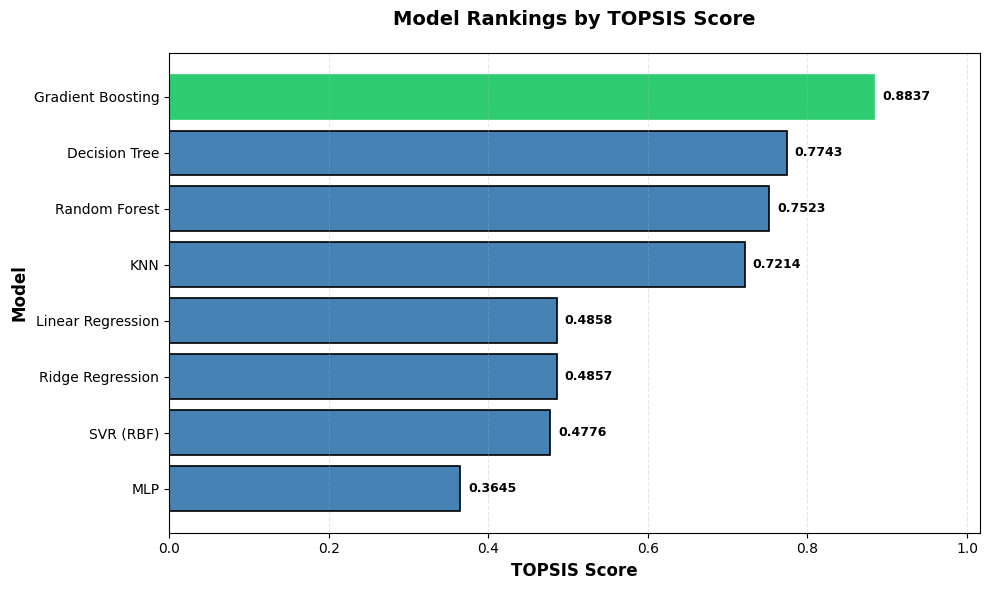

✓ Saved: results/model_topsis_scores.png


In [58]:
# Sort by TOPSIS score for visualization
df_viz = df_ranked.sort_values('TOPSIS_Score', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))

# Create horizontal bar chart
bars = ax.barh(df_viz['Model'], df_viz['TOPSIS_Score'], 
               color='steelblue', edgecolor='black', linewidth=1.2)

# Highlight top model
top_idx = df_viz['TOPSIS_Score'].idxmax()
bars[list(df_viz.index).index(top_idx)].set_color('#2ecc71')

# Add value labels
for i, (idx, row) in enumerate(df_viz.iterrows()):
    ax.text(row['TOPSIS_Score'] + 0.01, i, f"{row['TOPSIS_Score']:.4f}", 
            va='center', fontsize=9, fontweight='bold')

ax.set_xlabel('TOPSIS Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Model Rankings by TOPSIS Score', fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, max(df_viz['TOPSIS_Score']) * 1.15)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('results/model_topsis_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: results/model_topsis_scores.png")